# Differential analysis of protein expression from breast cancer subtypes
For this lesson, we will take the quantitative proteomics data from the following publication, "Proteogenomic Landscape of Breast Cancer Tumorigenesis and Targeted Therapy" (Cell, 2020). 

Here is the author's summary of the work:

The integration of mass spectrometry-based proteomics with next-generation DNA and RNA sequencing profiles tumors more comprehensively. Here this “proteogenomics” approach was applied to 122 treatment-naive primary breast cancers accrued to preserve post-translational modifications, including protein phosphorylation and acetylation. Proteogenomics challenged standard breast cancer diagnoses, provided detailed analysis of the ERBB2 amplicon, defined tumor subsets that could benefit from immune checkpoint therapy, and allowed more accurate assessment of Rb status for prediction of CDK4/6 inhibitor responsiveness. Phosphoproteomics profiles uncovered novel associations between tumor suppressor loss and targetable kinases. Acetylproteome analysis highlighted acetylation on key nuclear proteins involved in the DNA damage response and revealed cross-talk between cytoplasmic and mitochondrial acetylation and metabolism. Our results underscore the potential of proteogenomics for clinical investigation of breast cancer through more accurate annotation of targetable pathways and biological features of this remarkably heterogeneous malignancy.


Today we will use the underlying data to learn about what proteins are changing between the Luminal A and Luminal B samples of breast cancer that were examined in this study.

In [93]:
#@title Getting started { display-mode: "form" }
#@markdown Set up the environment, and download the raw data from ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) used throughout the praktikum:
#@markdown - Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

#@markdown - Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install -U scikit-learn

#@markdown - Download ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) supplementary materials & store them under `/content/` as `Krug2020_S1.xlsx` etc
!wget -nv -O Krug2020_S1.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx
!wget -nv -O Krug2020_S2.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx
!wget -nv -O Krug2020_S3.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx

#@markdown - Import modules from numpy, pandas, seaborn, sklearn
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#@markdown - Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

#@markdown - Clone the GitHub repository into your Colab environment
!git clone https://github.com/evocellnet/sysbio_teaching.git

def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

'rm' is not recognized as an internal or external command,
operable program or batch file.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'git' is not recognized as an internal or external command,
operable program or batch file.


# Import the required libraries 

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.stats.multitest

from scipy.stats import ttest_ind

# Load the z-score normalized data into a pandas DataFrame 
This should point to where the csv file is located on your own computer. 

Why is this data z-scored?

In [95]:
df = pd.read_csv('/content/sysbio_teaching/09_Univariate_analysis/CPTAC_2020_BR_proteomics_annotated.csv', low_memory = False)
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 10.4+ MB


# Move forward with only complete data
We will only take proteins that were identified in all samples, and exlude those with missing quantification values.

As an aside, some proteins may not be identified or quantified in a particular sample for a number of reasons. It is possible that the underlying biology of the tumor sample is different, or that the protein was below the limit of detection of the mass spectrometer used to identify the peptides from the given protein. Additionally, there are a number of possible explanaitions stemming from the analytical chemistry and the study design that we will not cover.

We could "gap-fill" these missing values using machine learning or simple imputation to include proteins with missing values; however, here with over 7,000 proteins quantified in union, it is  enough for us to move forward and try to make some conclusions for the class.


In [96]:
df.replace(r'\s+', np.nan, regex=True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7767 entries, 0 to 10102
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 8.1+ MB


# Define and compare the two groups 
Here we will move forward with the tumors annotated clinically as luminal A and luminal B. 

First, pull out the subtypes, and then perform a t-test to generate p-values for all proteins quantified in luminal A and luminal B.

We can also try with the other subtypes: Her2 and Basal


In [97]:
Lum_A = df.filter(like = 'LumA')
Lum_B = df.filter(like = 'LumB')

In [98]:
# Perform a t-test on the normalized-data
t, p = ttest_ind(Lum_A, Lum_B, axis=1)

print(p)

[0.42014438 0.16348083 0.87162223 ... 0.05123831 0.62202192 0.17925879]


# Use the Benjamini-Hochberg procedure to correct for multiple hypothesis testing.
To move forward, we need to correct for multiple hypothesis testing. Consider that if we were only looking at the expression of the Estrogen Receptor (ESR1), for example, we would only need to compare the expression of this one gene across samples. However, consider that we are trying to assert whether any of the >7,000 proteins identified change signicantly between the two cancer subtypes, so instead of one statistical test, we are performing thousands.

If we have a p-value of 0.02 for a single statistical test, that would mean that if our null hypothesis is true, there would only be a 2% chance of obtaining our observed test statistic or a more extreme result. Since this is a small probability, we could reject our null hypothesis and say that the means are significantly different. However, if we want to find significant changes in many features in a large dataset, where we have thousands of statistical tests, we have a higher probability of false positives.

We can correct for this using the Benjamini-Hochberg (BH) correction. This is done by i) getting all p-values, ii) arranging the p-values from smallest to largest and assigning a rank to each one, and iii) calculating the Benjamini-Hochberg critical value for each p-value. 

Calculating the critical values is done with the following equation:

padj = (i/m)*Q

where the adjusted p-value, padj, is equal to i,the rank of the p-value, divided by m, the total number of tests, multiplied by the chosen false discovery rate, Q. 

Here, in this example, we define the stringency of Q, the false discovery rate, as 0.05. This means we have a 5% expected false-postive rate, even with correction. Later, let's change this to 0.1% 1% or 10%, for example, to be more conservative about the number significant results that could actually just be due to chance and see what happens

Let's also perform the analysis without multiple hypothesis testing to understand what happens when we do not correct for the number of tests

In [99]:
#p_adj = np.multiply(p, len(p) / np.arange(len(p), 0, -1))
p_adj_with_sorting = (scipy.stats.rankdata(p) / len(p)) * 0.05
p_adj_statsmodels = statsmodels.stats.multitest.multipletests(p, method='fdr_bh')[1]

p_unadj = p

# Check correlations with reference implementation in statsmodels package
print(np.corrcoef(p_adj_statsmodels, p_adj))
print(np.corrcoef(p_adj_statsmodels, p_adj_with_sorting))

p_adj = p_adj_statsmodels

[[1. 1.]
 [1. 1.]]
[[1.         0.98008941]
 [0.98008941 1.        ]]


What does this adjustment actually do to our p-values?

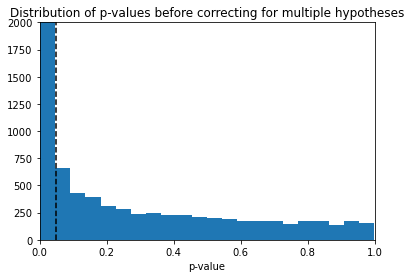

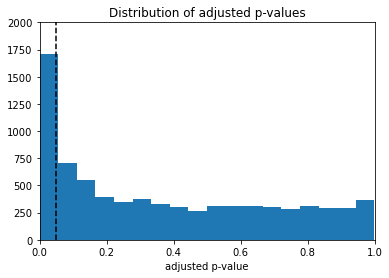

In [100]:
plt.hist(np.ndarray.tolist(p_unadj), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of p-values before correcting for multiple hypotheses")
plt.xlabel("p-value")
plt.xlim([0, 1])
plt.ylim([0,2000])
plt.show()

plt.hist(np.ndarray.tolist(p_adj), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of adjusted p-values")
plt.xlabel("adjusted p-value")
plt.xlim([0, 1])
plt.ylim([0,2000])
plt.show()

Let's plot adjusted p-values compared to p-values and see visually what happens in a bit more detail. For this figure, we will bound the figure limits by 1, however, note that adjusting p-values leads to values much higher than this.

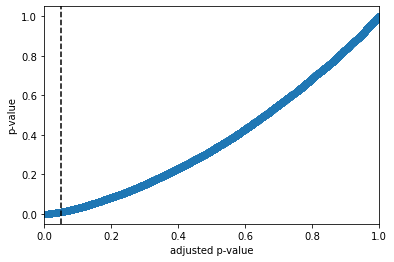

In [101]:
plt.scatter(p_adj, p_unadj)
plt.xlim([0, 1])
plt.axvline(x=0.05, linestyle="--", color="black")
#plt.axvline(y=0.05, linestyle="--", color="black")
plt.xlabel("adjusted p-value")
plt.ylabel("p-value")
plt.show()

# Next, define a fold-change cutoff and get mean Log2-transformed fold-changes for Luminal A vs Luminal B

Now that we have adjusted our statistical confidence for the number of statistical tests we performed, the next thing to do is to assert a fold-change. We assume that anything strongly upregulated or downregulated in Luminal A vs Luminal B is important for the underlying biology. Perhaps in luminal A, some signaling pathway or set of transcription factors is strongly upregulated to promote cancer cell proliferation or metastisis. 

Here we will say that anything that changes over 2-fold is significant and worth additonal analysis or some sort of follow up. We can also relax or increase the fold-change, or specify the value relative to the standard deviation of fold-changes.

First, we calculate the mean protein expression between the two groups for each of the 7,000+ quantified proteins:

0       -0.175088
4       -0.320910
6        0.046603
7        1.086099
8        1.242674
           ...   
10096    0.049198
10098   -0.496785
10099    0.691313
10101    0.323386
10102    0.297509
Length: 7767, dtype: float64


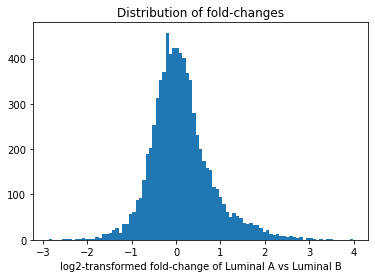

In [109]:
log2fc = np.mean(Lum_A, axis=1) - np.mean(Lum_B, axis=1)
print(log2fc)

plt.hist(log2fc, bins='auto')
plt.title("Distribution of fold-changes")
plt.xlabel("log2-transformed fold-change of Luminal A vs Luminal B")
plt.show()

fc_cutoff = 2.0
# also plot distribution of fold changes.....



# Get the list of differentially expressed proteins

Now let's get the list of proteins that meets both our criteria for statistical significance and fold change for when we have i) adjusted, and ii) non-adjusted p-values:

In [110]:
de_genes = np.logical_and(p_adj < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))
de_genes_unadjusted = np.logical_and(p_unadj < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))

Let's now plot what changes in between these two subtypes of breast cancer for the corrected data with our adjusted p-values and fold-changes.

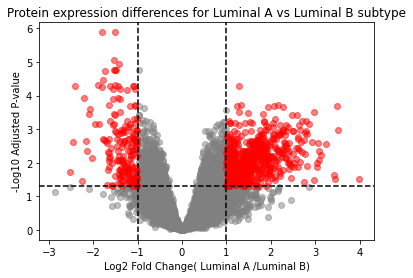

In [111]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

let's plot what changes in between these two subtypes of breast cancer when no correction is applied:

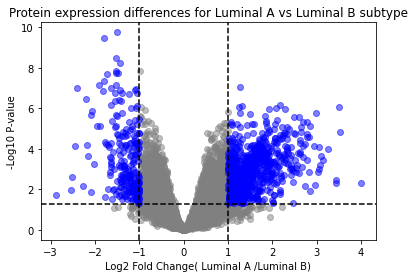

In [112]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes_unadjusted], -np.log10(p_unadj[~de_genes_unadjusted]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes_unadjusted], -np.log10(p_unadj[de_genes_unadjusted]), c="blue", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

The plots look pretty similar, but when we use corrected values, we end up excluding a number of proteins as no longer significant. Indeed, now over 100 proteins have been excluded due to our correction for multiple hypothesis testing.

In [113]:
de_genes.sum()

740

In [114]:
de_genes_unadjusted.sum()

903

what happens if we are more stringent with or FDR cutoff? Let's now set the FDR to 1.0% cutoff?

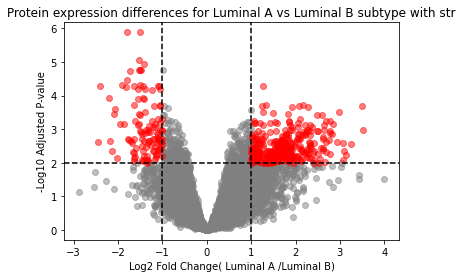

445

In [115]:

de_genes = np.logical_and(p_adj < 0.01, np.abs(log2fc) > np.log2(fc_cutoff))



fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black") 
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype with str")
plt.show()

de_genes.sum()




Let's now get the differentially expressed proteins as their own dataframe so we can look for biological significance between the two cancer subtypes:

# what happens between Basal and Her2 subtypes
We will make some changes, and specifiy different cutoffs here
For the class, let's change the values

[0.4721778  0.71114113 0.75917185 ... 0.57163102 0.86283322 0.13477873]


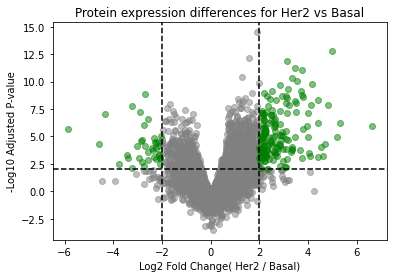

198

In [116]:
# get Basal and Her2 values
Basal = df.filter(like = 'Basal')
Her2 = df.filter(like = 'Her2')

# get log2FC values
log2fc = np.mean(Her2, axis=1) - np.mean(Basal, axis=1)

# perform t-test
t, p = ttest_ind(Basal, Her2, axis=1)
print(p)

# get corrected p-values
p_adj = np.multiply(p, len(p) / np.arange(len(p), 0, -1))

fc_cutoff = 4
de_genes = np.logical_and(p_adj < 0.01, np.abs(log2fc) > np.log2(fc_cutoff))

fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="green", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black") 
ax.set_xlabel("Log2 Fold Change( Her2 / Basal)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Her2 vs Basal")
plt.show()

de_genes.sum()

What can we say between the two comparisons about the differences between breast cancer subtypes? Even at a high level? Note that we increased the cutoff to a +/- 4-fold change in abundance.

# Making sense of quantitative changes

What might make sense for statistical cutoffs/thresholds if we had an even larger dataset (~20,000 genes instead of ~7,000 proteins)? Should we relax our adjusted p-value cutoff?



How do we prioritize or move forward with our results? Let's assume, like the authors, we are trying to better understand the biology of breast cancer subtypes.

Should we examine results at the level of single proteins, or connect their role(s) to different pathways?

Should we expect proteins involved in the same biological process to change? What about protein complexes?

In the case of Her2 breast cancer, we know that Human Epidermal Growth Factor Receptor 2 (HER2) is activated.  
Alone or in a group, write pseudocode to layer proteins in the epidermal growth factor pathway on top of the above volcano plot.
Do you expect proteins in this pathway to be significantly different between HER2 and Basal breast cancer subtypes?



In [117]:
# add differentially expressed genes, fold change, and adj-pvalues to the original df

# provide the full table without filtering...

df['de_genes'] = np.array(de_genes) # true/false column 
df['log2fc'] = np.array(log2fc)
df['adj_p'] = np.array(p_adj)

#get subset df where we only have differential expressed genes
DE_df = df.loc[df['de_genes'] == True]


In [78]:
print(DE_df)
# export df for the next steps...
#df.to_csv('out.csv', index=False)
#DE_df.to_csv('out_DE.csv', index=False)

                  id geneSymbol  numColumnsProteinObserved  \
33    NP_001074419.1      MYO1C                         17   
73       NP_004095.4       FASN                         17   
90       NP_006624.2     IQGAP2                         17   
128      NP_942133.1      ACACA                         17   
144      NP_002408.3      MKI67                         17   
...              ...        ...                        ...   
9144  NP_001277482.1    ADIPOR1                         15   
9208     NP_054901.1     ORMDL2                         16   
9309  NP_001244320.1       CD63                         17   
9437  NP_001245249.1    TP53I11                         17   
9610     NP_055214.1    TSPAN13                         17   

      numSpectraProteinObserved  protein_mw  percentCoverage  numPepsUnique  \
33                           26    120424.7             81.7            115   
73                         7494    276046.1             84.7            208   
90                